In [ ]:
import cv2 as cv
import tensorflow as tf
from tensorflow.keras import models,layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
import matplotlib.pyplot as plt
import os
import imghdr
import numpy as np
import random
import shutil

#prepare data

In [ ]:
data_dir = 'Car-Bike-Dataset'
img_error = 'img_error'
image_exts = ['jpeg','jpg','bmp','png']

In [ ]:
name_dir = os.listdir(data_dir)
len_dir = [len(os.listdir(os.path.join(data_dir, i))) for i in name_dir]
print(len_dir)

[2000, 2000]


In [ ]:
# dung de xoa cac dinh dang anh khong phu hop
def remove_img(data_dir , image_exts):
    for img in os.listdir(data_dir):
        for image in os.listdir(os.path.join(data_dir , img)):
            image_path = os.path.join(data_dir , img , image)
            try:
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    print('image not in ext {}'.format(image_path))
                    shutil.move(image_path,img_error)
            except Exception as e:
                print('Issure not image {}'.format(image_path))
                shutil.move(image_path,img_error)

In [ ]:
remove_img(data_dir, image_exts)

image not in ext Car-Bike-Dataset\Bike\Bike (113).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (114).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (132).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (136).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (138).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (17).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (177).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (179).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (181).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (182).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (183).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (184).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (26).png
image not in ext Car-Bike-Dataset\Bike\Bike (3).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (70).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (90).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (95).jpg
image not in ext Car-Bike-Dataset\Car\Car (15).JPG
image not in ext Car-Bike-Dataset\Car\

In [ ]:
len_dir_last = [len(os.listdir(os.path.join(data_dir, i))) for i in name_dir ]
print(len_dir_last)

[1983, 1998]


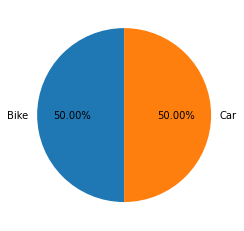

In [ ]:
plt.pie(len_dir , labels = name_dir , autopct='%1.2f%%', startangle = 90)
plt.show()

###### input image size format is 60
###### Batch size la 32
https://docs.w3cub.com/tensorflow~2.3/keras/preprocessing/image_dataset_from_directory


In [ ]:
IMAGE_SIZE = 60
BATCH_SIZE = 32
CHANNELS = 3

In [ ]:
Data = tf.keras.preprocessing.image_dataset_from_directory(
'Car-Bike-Dataset',
batch_size = 32,
image_size = (IMAGE_SIZE , IMAGE_SIZE),
shuffle = True
)

Found 3981 files belonging to 2 classes.


In [ ]:
print('Number Batch : {}'.format(len(Data)))

Number Batch : 125


In [ ]:
class_names = Data.class_names
len_class = len(Data.class_names)
print(class_names)
print(len_class)

['Bike', 'Car']
2


In [ ]:
# 1 cho biet kich thuoc cua mot anh va so anh trong 1 bo
# cho thay duoc nhan 0 - 1 duoc gan vao anh
for image_batch, label_batch in Data.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 60, 60, 3)
[0 1 1 1 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 1 0 1 1 1 0]


In [ ]:
# ham dung de show anh
def show_img(Data , number_img = [4,3]):
    plt.figure(figsize = (10 ,10))
    for image_batch, label_batch in Data.take(1):
        for i in range(number_img[0]*number_img[1]):
            ax = plt.subplot(number_img[0],number_img[1],i+1)
            plt.imshow(image_batch[i].numpy().astype('uint8'))
            plt.title(class_names[label_batch[i]]+' - label : {}'.format(label_batch[i].numpy()))
            plt.axis('off')

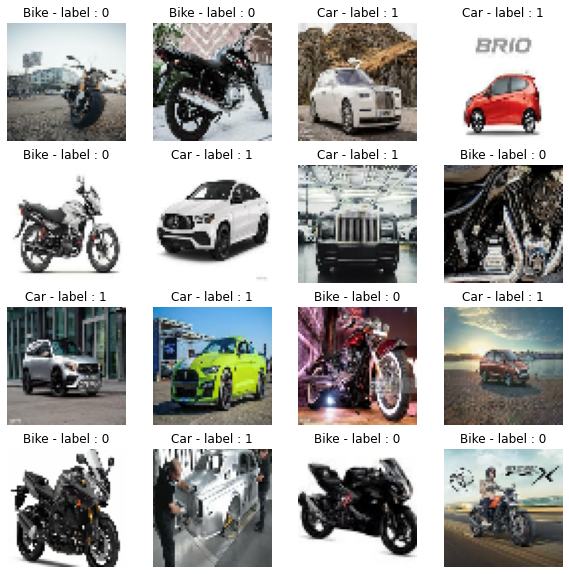

In [ ]:
show_img(Data , [4,4])

In [ ]:
# chia du lieu thanh 3 phan Train, Val , Test
def setting_data(data , train_scale = 0.8 , val_scale = 0.1, test_scale = 0.1,Shuffle = 1000):
    if Shuffle:
        data = data.shuffle(Shuffle,seed = 20)
    v_train = int(len(data)*0.8)
    v_val = int(len(data)*0.1)
    Train = data.take(v_train)
    Val = data.skip(v_train).take(v_val)
    Test = data.skip(v_train).skip(v_val)
    return Train, Val , Test

In [ ]:
Train , Val , Test = setting_data(Data,Shuffle = 40)

In [ ]:
print('Number Train : {}'.format(len(Train)))
print('Number Val : {}'.format(len(Val)))
print('Number Test : {}'.format(len(Test)))

Number Train : 100
Number Val : 12
Number Test : 13


In [ ]:
Train = Train.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
Val = Val.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
Test = Test.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

###https://www.tutorialspoint.com/how-can-tensorflow-be-used-to-configure-the-dataset-for-performance

#Build model

In [ ]:
def create_model(input_shape):
    rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1.0/255),
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),])
    model = tf.keras.Sequential([
        rescale,
        #data_augmentation
        # Note the input shape is the desired size of the image 150x150 with 3 bytes color
        # This is the first convolution
        Conv2D(filters=32,kernel_size=(3,3), activation='relu', input_shape = input_shape),
        MaxPooling2D(pool_size=(2,2)),
        # The second convolution
        Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.25),
        # The third convolution
        Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.25),
        # Flatten the results to feed into a DNN
        Flatten(),
        # 128 neuron hidden layer
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(1,  activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy()])
    return model

In [ ]:
input_shape = (BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE , CHANNELS)
model = create_model(input_shape)
model.build(input_shape = input_shape)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 60, 60, 3)           0         
                                                                 
 conv2d (Conv2D)             (32, 58, 58, 32)          896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 29, 29, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 27, 27, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 13, 13, 32)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (32, 13, 13, 32)         

In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
# cp_callbac: train or save model
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(Train,validation_data=Val, epochs=30 , batch_size = BATCH_SIZE,verbose = 1,callbacks=[cp_callback])

Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 0.6242 - binary_accuracy: 0.6325
Epoch 1: saving model to training_1\cp.ckpt
100/100 [==============================] - 126s 1s/step - loss: 0.6242 - binary_accuracy: 0.6325 - val_loss: 0.3890 - val_binary_accuracy: 0.8620
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.3047 - binary_accuracy: 0.8703
Epoch 2: saving model to training_1\cp.ckpt
100/100 [==============================] - 12s 120ms/step - loss: 0.3047 - binary_accuracy: 0.8703 - val_loss: 0.2697 - val_binary_accuracy: 0.8958
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.2543 - binary_accuracy: 0.8978
Epoch 3: saving model to training_1\cp.ckpt
100/100 [==============================] - 12s 118ms/step - loss: 0.2543 - binary_accuracy: 0.8978 - val_loss: 0.2231 - val_binary_accuracy: 0.9089
Epoch 4/30
100/100 [==============================] - ETA: 0s - loss: 0.2147 - binary_accuracy: 0.9137
Epoch 4: savin

Epoch 29/30
100/100 [==============================] - ETA: 0s - loss: 0.0369 - binary_accuracy: 0.9856
Epoch 29: saving model to training_1\cp.ckpt
100/100 [==============================] - 13s 129ms/step - loss: 0.0369 - binary_accuracy: 0.9856 - val_loss: 0.1416 - val_binary_accuracy: 0.9714
Epoch 30/30
100/100 [==============================] - ETA: 0s - loss: 0.0466 - binary_accuracy: 0.9837
Epoch 30: saving model to training_1\cp.ckpt
100/100 [==============================] - 12s 117ms/step - loss: 0.0466 - binary_accuracy: 0.9837 - val_loss: 0.1223 - val_binary_accuracy: 0.9766


In [ ]:
history.history.keys()

##https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

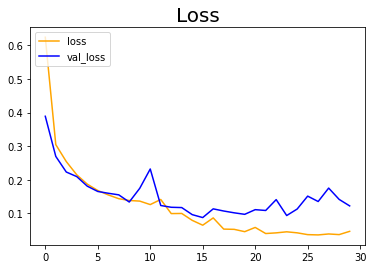

In [ ]:
plt.plot(history.history['loss'], color = 'orange',label= 'loss')
plt.plot(history.history['val_loss'], color = 'blue',label= 'val_loss')
plt.title('Loss',fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

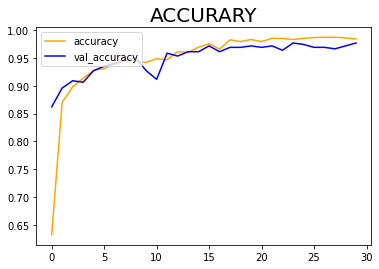

In [ ]:
plt.plot(history.history['binary_accuracy'], color = 'orange',label= 'accuracy')
plt.plot(history.history['val_binary_accuracy'], color = 'blue',label= 'val_accuracy')
plt.title('ACCURARY',fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
Test_model = model.evaluate(Test)

13/13 [==============================] - 54s 28ms/step - loss: 0.0786 - binary_accuracy: 0.9880


### Loadiing model

In [ ]:
chack_path = 'training_1'

In [ ]:
os.listdir(checkpoint_dir)

['checkpoint', 'cp.ckpt.data-00000-of-00001', 'cp.ckpt.index']

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)

In [ ]:
new_model = create_model(input_shape)

In [ ]:
new_model.load_weights(latest)

In [ ]:
def test_img(model , test_ds ,number = [3,3] , img_size = 60):
    list_name = os.listdir(test_ds)
    number_img = len(list_name)
    plt.figure(figsize = (15 ,15))
    for img in range(number[0]*number[1]):
        index_img = random.randint(0,number_img-1)
        name_img = list_name[index_img]
        path_img = os.path.join(test_ds , name_img)
        test_image2 = tf.keras.utils.load_img(path_img, target_size=(img_size,img_size))
        test_image2 = np.expand_dims(test_image2, axis=0)
        prediction = new_model.predict(test_image2)
        if prediction > 0.5:
            title = 'Car with accuracy {}'.format(prediction)
        else:
            title = 'Bike with accuracy {}'.format(1- prediction)

        plt.subplot(number[0], number[1], img +1)
        plt.imshow(test_image2[0])
        plt.axis('off')
        plt.title(title)

1/1 [==============================] - 0s 33ms/step


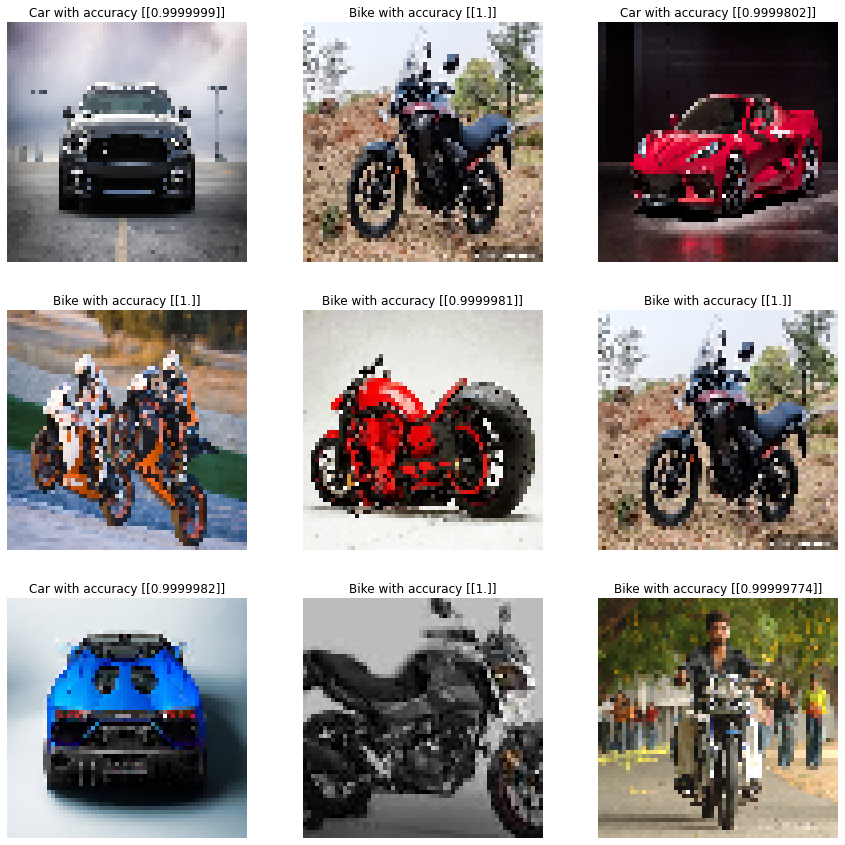

In [ ]:
dir_test_model = 'Test'
test_img(new_model , dir_test_model , [3,3],60)